# Developing a toy model for exploring uncertainties in the Pearson correlation coefficient

We want a model framework that produces "climate-like" signals with the following properties:
- ability to dial up/down the serial correlation
- ability to dial up/down the number of ensemble members to produce realistic smoothing
- explore the effect of trends

Things to maybe explore:
- How wrong can the "standard" block-bootstrap approach be?
- How do different significance tests perform?
- What is the effect of ensemble averaging?
- Can we usefully quantify the impact of trends which are often not removed?
- What do the results mean for the signal-to-noise paradox?
- How sensitive are other metrics? e.g MSE?

In [1]:
import numpy as np

import xarray as xr



import cartopy
import cartopy.crs as ccrs

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import Divider, Size

from src import ar_model, utils

/datasets/work/oa-dcfp/work/squ027/.conda/envs/Squire_2022_correlation/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
DATA_DIR = "../../../Squire_2022_CAFE-f6/data/"

cartopy.config["pre_existing_data_dir"] = f"{DATA_DIR}/cartopy-data"
cartopy.config["data_dir"] = f"{DATA_DIR}/cartopy-data"

In [4]:
plt.rcParams["figure.figsize"] = (12, 6)

## Load some example real signals to explore and replicate

In [5]:
can = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.precip_global.zarr"
)
can["t_ref"] = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.t_ref_global.zarr"
)["t_ref"]
can["sst"] = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.sst_global.zarr"
)["sst"]

ec = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.precip_global.zarr"
)
ec["t_ref"] = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.t_ref_global.zarr"
)["t_ref"]
ec["sst"] = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.sst_global.zarr"
)["sst"]
ec["slp"] = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.slp_global.zarr"
)["slp"]

## What do the partial autocorrelation functions look like for these fields?

In [15]:
pacf_can = utils.acf(can, partial=True, nlags=3).compute()
pacf_ec = utils.acf(ec, partial=True, nlags=3).compute()

In [16]:
def plot_pacf_lags(pacf, lags, title=None, figsize=None, vrange=(-1, 1)):

    nrows = len(pacf)
    ncols = len(lags)
    if figsize is None:
        figsize = (5.0 * ncols, 2.5 * nrows)

    fig = plt.figure(figsize=figsize)
    axs = fig.subplots(
        nrows,
        ncols,
        sharex=True,
        sharey=True,
        subplot_kw=dict(projection=ccrs.PlateCarree(180)),
    )

    bounds = np.linspace(vrange[0], vrange[1], 21)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds) - 1)

    for y, l in enumerate(lags):
        for x, v in enumerate(pacf.keys()):
            ax = axs[x, y]
            p = (
                pacf[v]
                .sel(lag=l)
                .plot(
                    ax=ax,
                    transform=ccrs.PlateCarree(),
                    vmin=vrange[0],
                    vmax=vrange[1],
                    norm=norm,
                    cmap="RdBu_r",
                    add_colorbar=False,
                )
            )
            p.axes.coastlines(color=[0.2, 0.2, 0.2], linewidth=0.75)

            ax.set_title(f"{v} | lag {l}")

    h = [Size.Fixed(figsize[0] / 12), Size.Fixed(figsize[0] - figsize[0] / 6)]
    v = [Size.Fixed(0), Size.Fixed(0.15)]
    divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
    cbar_ax = fig.add_axes(
        divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1)
    )
    fig.colorbar(p, cax=cbar_ax, orientation="horizontal")

    if title:
        fig.suptitle(title)

    return fig

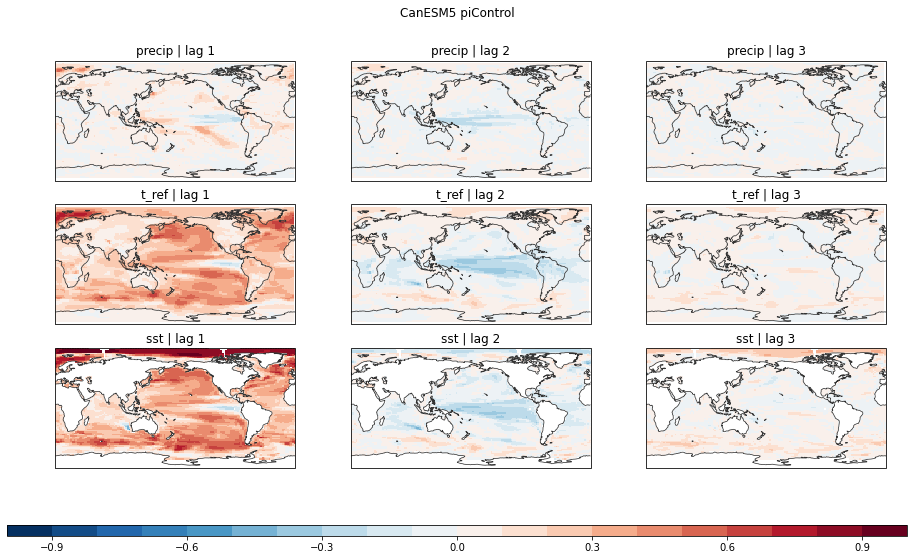

In [21]:
_ = plot_pacf_lags(pacf_can, lags=[1, 2, 3], title="CanESM5 piControl")

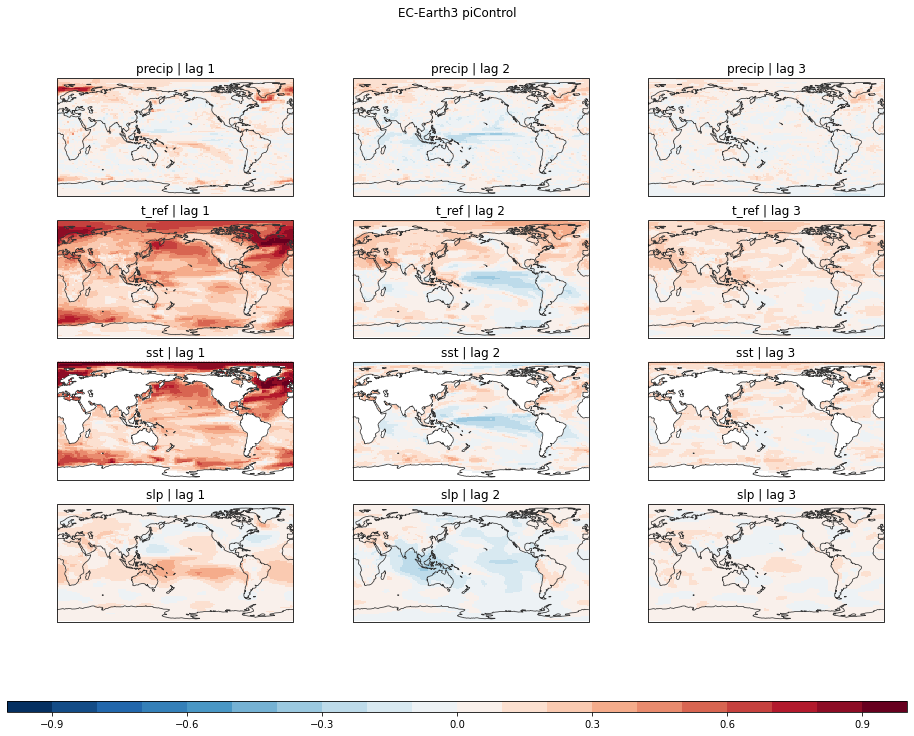

In [22]:
_ = plot_pacf_lags(pacf_ec, lags=[1, 2, 3], title="EC-Earth3 piControl")

## Let's look at how the order 2 coefficient vary across the globe

In [23]:
order = 2

coeffs_can = ar_model.yule_walker(can, order=order).compute()
coeffs_ec = ar_model.yule_walker(ec, order=order).compute()

In [24]:
def plot_coeffs(coeffs, figsize=None):

    ncols = len(coeffs)
    if figsize is None:
        figsize = (5.0 * ncols, 4)

    fig = plt.figure(figsize=figsize)
    axs = fig.subplots(
        1,
        ncols,
        sharex=True,
        sharey=True,
    )

    for i, v in enumerate(coeffs.keys()):
        ax = axs[i]
        p = ax.scatter(
            coeffs[v].sel(coeff=1),
            coeffs[v].sel(coeff=2),
            s=10,
            c=coeffs[v].sel(coeff=0),
        )
        ax.set_xlabel(r"$\phi_{1}$")
        ax.set_ylabel(r"$\phi_{2}$")
        ax.set_title(v)
        ax.grid()

    h = [Size.Fixed(figsize[0] / 12), Size.Fixed(figsize[0] - figsize[0] / 6)]
    v = [Size.Fixed(-0.3), Size.Fixed(0.15)]
    divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
    cbar_ax = fig.add_axes(
        divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1)
    )
    fig.colorbar(p, cax=cbar_ax, orientation="horizontal", label=r"$\sigma_{\epsilon}$")

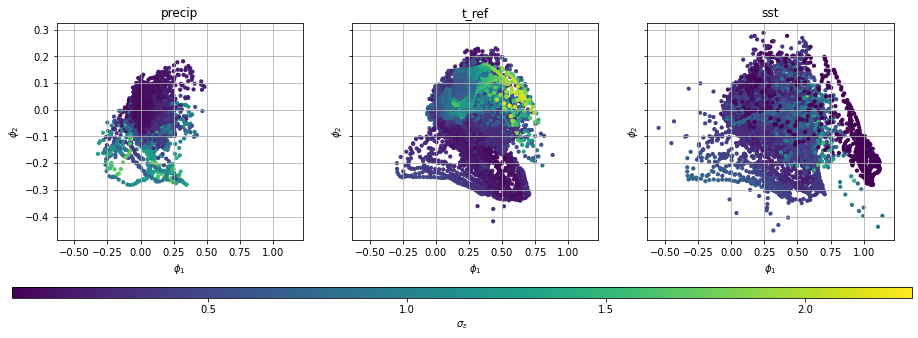

In [25]:
plot_coeffs(coeffs_can)

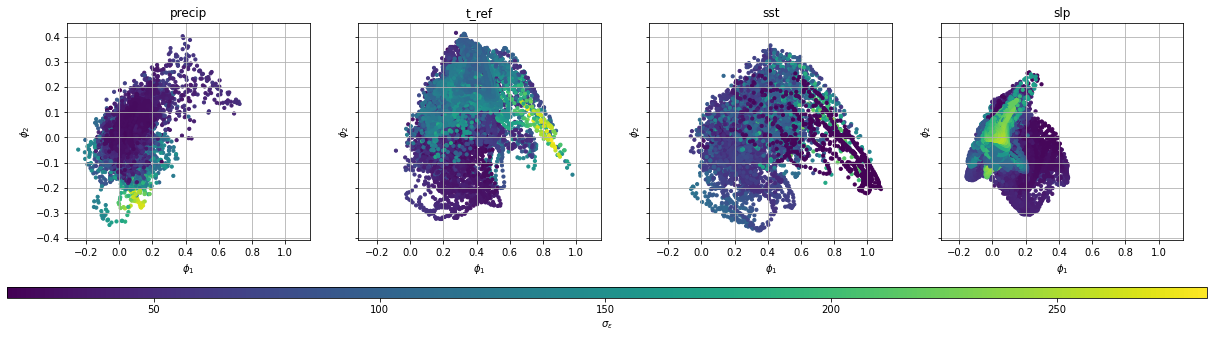

In [26]:
plot_coeffs(coeffs_ec)

## What about coming up with some example cases with similar ACFs to, for example:
- **s1**: highly correlated sst index (e.g. box over Atlantic subpolar gyre - https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020GL091307, https://link.springer.com/article/10.1007/s00382-014-2212-7)
- **s2**: nao index (e.g. https://www.nature.com/articles/s41612-019-0071-y)
- **s3**: "independent" precip index (e.g. box over Australia)

## **s1**: Atlantic subpolar gyre

-------------------

In [31]:
spg = utils.detrend(
    utils.extract_subpolar_gyre_region(ec["sst"]),
)

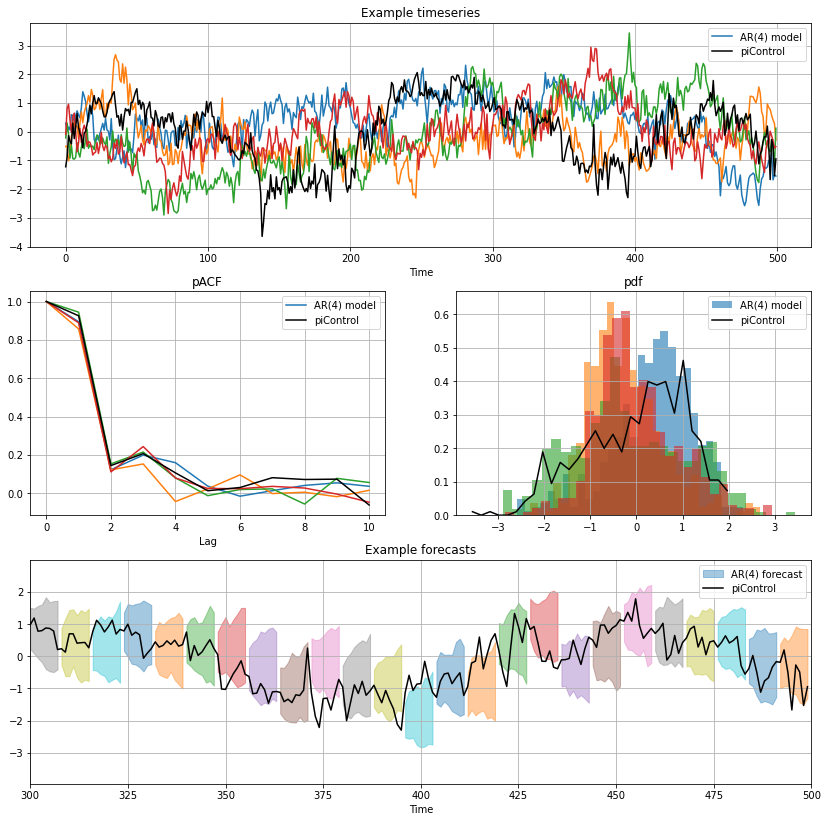

In [ ]:
n_times = 50
n_samples = 100
n_members = 100
rolling_means = [2, 4, 8]

obsv = ar_model.generate_samples_like(
    spg,
    order="select_order",
    n_times=n_times,
    n_samples=n_samples,
    rolling_means=rolling_means,
    plot_diagnostics=True,
)

fcst = ar_model.generate_samples_like(
    spg,
    order="select_order",
    n_times=n_times,
    n_samples=n_samples,
    n_members=n_members,
    rolling_means=rolling_means,
    plot_diagnostics=False,
)

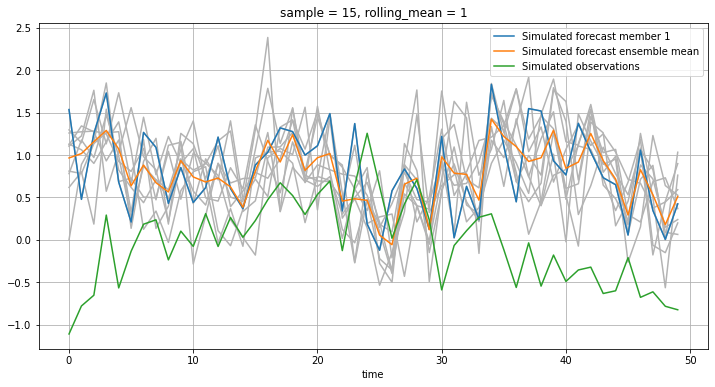

In [37]:
rolling_mean = 1
sample = 15

s1_fcst.sel(sample=sample, rolling_mean=rolling_mean).plot.line(
    x="time", color=[0.7, 0.7, 0.7], add_legend=False
)
s1_fcst.sel(sample=sample, rolling_mean=rolling_mean).sel(member=1).plot(
    label="Simulated forecast member 1"
)
s1_fcst.sel(sample=sample, rolling_mean=rolling_mean).mean("member").plot(
    label="Simulated forecast ensemble mean"
)
s1_obsv.sel(sample=sample, rolling_mean=rolling_mean).plot(
    label="Simulated observations"
)

plt.legend()
plt.grid()

In [38]:
import xskillscore as xs

test = xs.pearson_r(s1_fcst.mean("member"), s1_obsv, dim="time")

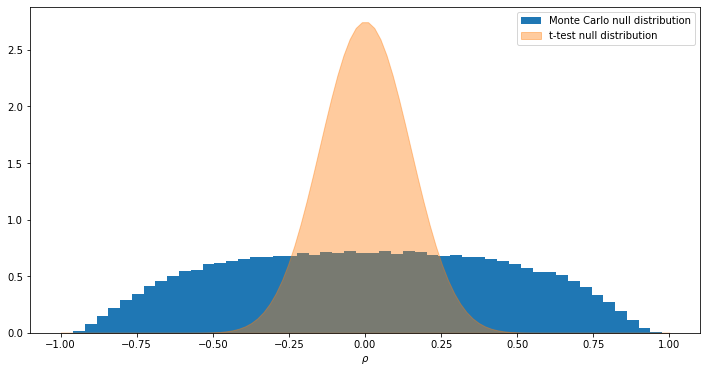

In [39]:
plt.hist(
    test.sel(rolling_mean=8),
    bins=50,
    density=True,
    label="Monte Carlo null distribution",
)

# t-test
r = np.linspace(-1, 1, 100)
plt.fill_between(
    r, utils.student_t(50, r), color="C1", alpha=0.4, label="t-test null distribution"
)

plt.legend()
_ = plt.xlabel(r"$\rho$")

### **s2**: NAO index

In [215]:
def north_atlantic_oscillation(ds):
    """Return the nao index used by Smith et al. (2020)"""
    Azores_box = utils.extract_lon_lat_box(
        ds, box=[332, 340, 36, 40], weighted_average=True
    )
    Iceland_box = utils.extract_lon_lat_box(
        ds, box=[335, 344, 63, 70], weighted_average=True
    )
    nao = Azores_box - Iceland_box
    return nao - nao.mean("time")

In [216]:
ec_nao = north_atlantic_oscillation(ec)["slp"]
s2_coeffs = yule_walker(ec_nao, order=2).compute()

In [217]:
ntimes = len(ec_nao)

ar = np.concatenate(([1], -s2_coeffs.sel(coeff=[1, 2])))
s2_process = ArmaProcess(ar)

s2 = s2_process.generate_sample(nsample=ntimes, scale=s2_coeffs.sel(coeff=0).item())

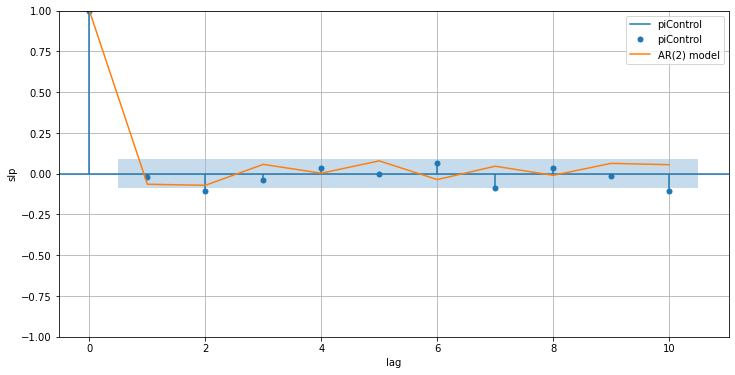

In [218]:
plot_pacf(s2, lags=10, method="ywm", label="piControl")
acf(ec_nao, partial=True).plot(label="AR(2) model")

plt.title("")
plt.grid()
_ = plt.legend()

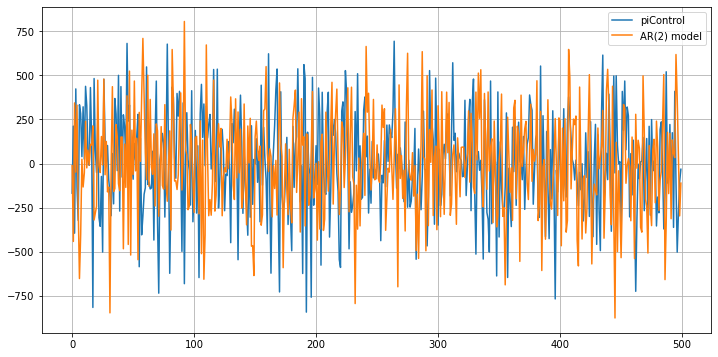

In [219]:
plt.plot(ec_nao, label="piControl")
plt.plot(s2, label="AR(2) model")

plt.grid()
_ = plt.legend()

### Can we build ensemble forecasts with these models?

In [247]:
np.random.standard_normal(50)

array([-1.51745513,  1.92093175, -0.94125319, -1.0254181 , -0.25472485,
        2.19916568, -0.52269948,  0.28218351, -1.76841859, -1.37404369,
       -0.81521254,  2.95730612,  0.36609388,  0.05985637,  2.25451834,
        0.54558068,  0.06496594,  0.01883081,  0.07962581,  1.22004724,
       -1.52973451, -0.5943884 , -0.04607343, -1.04526054, -0.06170846,
        1.7054837 ,  1.31431271,  0.2089277 ,  0.01505166, -1.12590226,
        2.03190828,  0.17505528,  1.35099439, -0.62060778, -1.01546363,
       -0.90103776, -0.79471061,  1.53516759, -0.15305782,  1.57450018,
        0.41350349,  0.21609303, -0.33649965,  0.40340807,  0.32493055,
       -0.40402901, -0.57817948,  0.64798204,  0.62280542,  0.39806471])

In [249]:
init(50)

TypeError: 'numpy.ndarray' object is not callable

In [265]:
def init(size):
    return np.zeros(size)

In [266]:
ntimes = 50
nensemble = 10

ar = np.concatenate(([1], -s1_coeffs.sel(coeff=[1, 2])))
s1_process = ArmaProcess(ar)

s1_obsv = s1_process.generate_sample(
    nsample=ntimes, scale=s1_coeffs.sel(coeff=0).item(), distrvs=init
)

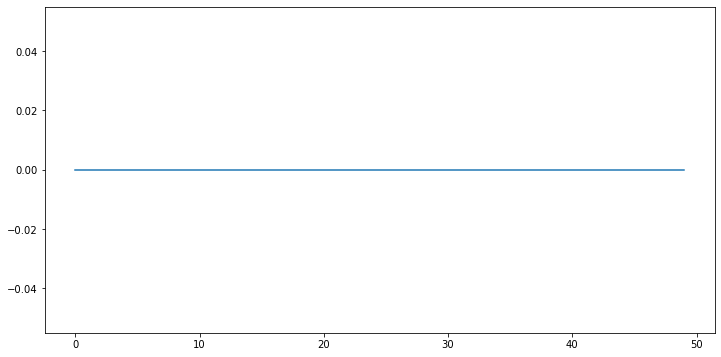

In [267]:
plt.plot(s1_obsv)

In [78]:
from statsmodels.tsa.ar_model import AutoReg

In [149]:
test = can["sst"].sel(lat=60, lon=180, method="nearest").compute().values

In [203]:
f = AutoReg(test, lags=2, trend="n").fit()

In [204]:
f.params

array([0.54150323, 0.01317337])

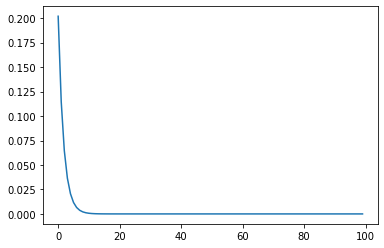

In [205]:
plt.plot(f.forecast(100))

In [206]:
from statsmodels.regression.linear_model import yule_walker

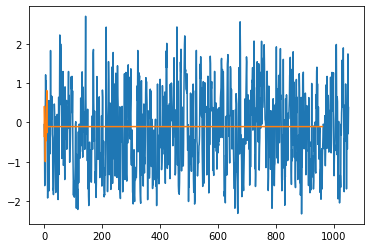

In [181]:
plt.plot(test)

plt.plot(f.predict(start=1040, end=2000, dynamic=1050))

In [ ]:
def AutoReg(ds, dim="time", partial=False, nlags=10):
    """Vectorized Autocorrelation Function for xarray objects"""
    import statsmodels.api as sm

    def _acf(data, nlags, partial):
        if partial:
            return sm.tsa.pacf(data, nlags=nlags)
        else:
            return sm.tsa.acf(data, nlags=nlags)

    return xr.apply_ufunc(
        _acf,
        ds,
        kwargs=dict(nlags=nlags, partial=partial),
        input_core_dims=[[dim]],
        output_core_dims=[["lag"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        dask_gufunc_kwargs=dict(output_sizes={"lag": nlags + 1}),
    ).assign_coords({"lag": range(nlags + 1)})

In [73]:
def init(size):
    
    return arma_process.generate_sample(nsample=size[0])

In [74]:
nsamples = 100
ntimes = 50

ar = np.array([1, -0.8])

arma_process = ArmaProcess(ar)
s = arma_process.generate_sample(nsample=(nsamples, 2), distrvs=init, axis=0)

In [77]:
s.shape

(100,)

In [68]:
s.plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [54]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [55]:
import statsmodels.tsa.ar_model

In [ ]:
AutoReg()

In [52]:
np.std(s)

1.2884386827350243

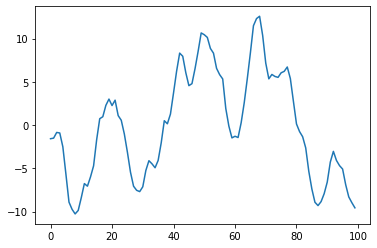

In [75]:
plt.plot(s)

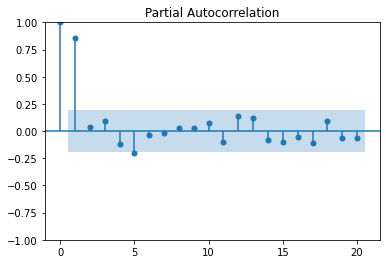

In [45]:
_ = plot_pacf(s, method="ywm")